In [23]:
# import basic torch
import torch
from torch import nn

# import base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import vision libraries
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.v2 import ToTensor

In [24]:
train_data = datasets.FashionMNIST(
    root= 'data', # where to down the data
    train= True, # do we want train data?
    download=True, # to download it locally?
    transform = ToTensor(), # how do we want to transform the data
    target_transform=None, # how do we want to transform the labels
)

test_data = datasets.FashionMNIST(
    root= 'data', # where to down the data
    train= False, # do we want train data?
    download=True, # to download it locally?
    transform = ToTensor(), # how do we want to transform the data
    target_transform=None, # how do we want to transform the labels
)

/home/anikeet/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [25]:
class_names = train_data.classes

In [26]:
image, label = train_data[0]

image.shape, class_names[label]

(torch.Size([1, 28, 28]), 'Ankle boot')

Text(0.5, 1.0, 'Ankle boot')

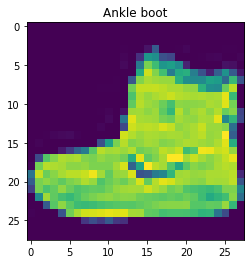

In [27]:
plt.imshow(image.squeeze())
plt.title(class_names[label])

(-0.5, 27.5, 27.5, -0.5)

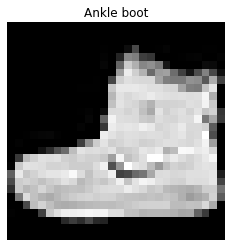

In [28]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)

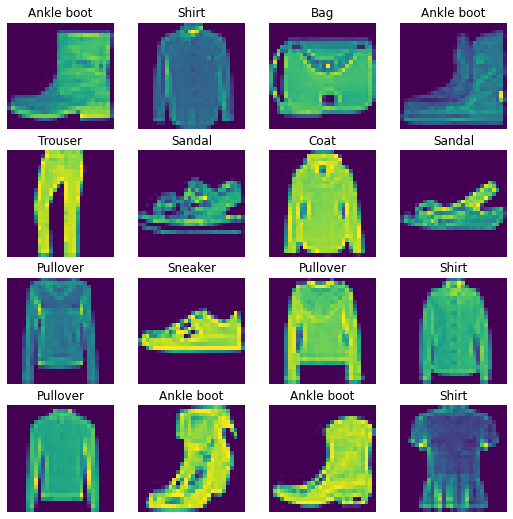

In [29]:
torch.manual_seed(42)
fig = plt.figure(figsize =(9, 9))
rows, cols = 4, 4
for i in range(1, (rows * cols) + 1):
    rand_index = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[rand_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

In [30]:
## Loading data

BATCH_SIZES = 32

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset= train_data,
                              batch_size= BATCH_SIZES,
                              shuffle=True,)

# dosent matter if data is shuffeled in test data, its easier for manually looking through when
# dataset is not shuffeled
test_dataloader = DataLoader(dataset= test_data,
                              batch_size= BATCH_SIZES,
                              shuffle=False,)

print(train_dataloader, test_dataloader)
print("size ", len(train_dataloader), len(test_dataloader))

<torch.utils.data.dataloader.DataLoader object at 0x7fbd789e62f0> <torch.utils.data.dataloader.DataLoader object at 0x7fbd789e7f40>
size  1875 313


In [31]:
train_feature_batch, train_label_batch  = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

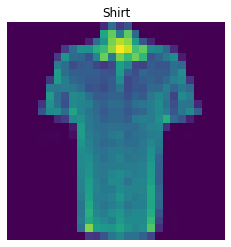

In [32]:
torch.manual_seed(42)

rand_idx = torch.randint(0, len(train_feature_batch), size= [1]).item()
img, label = train_feature_batch[rand_idx], train_label_batch[rand_idx]

plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [33]:
flatten_model = nn.Flatten()

x = train_feature_batch[0]

output = flatten_model(x)

print(x.shape, output.shape)

torch.Size([1, 28, 28]) torch.Size([1, 784])


In [34]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape:int,
                hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features= hidden_units),
            nn.Linear(in_features=hidden_units, out_features= output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [35]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(28*28, 10, len(class_names))
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [36]:
!pip install torchmetrics

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

from torchmetrics.classification import Accuracy

acc_fn = Accuracy(task = 'multiclass', num_classes = len(class_names))

Defaulting to user installation because normal site-packages is not writeable


In [37]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("File already exits, skipping downloading")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

File already exits, skipping downloading


In [38]:
# machine learning is very experimental
# lets check how fast out model run
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device: torch.device):
    total_time =   end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [39]:
start = timer()

end = timer()

print_train_time(start, end, "cpu")

Train time on cpu: 0.000 seconds


2.5639999989834905e-05

In [40]:
torch.manual_seed(42)
from tqdm.auto import tqdm
train_time_on_cpu = timer()
epochs = 3
for epoch in range(epochs):
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0.forward(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        if batch % 400 == 0:
            print(f'Look at {batch * len(X)} / {len(train_dataloader.dataset)} samples')

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
        for batch_test , (X_test, y_test) in enumerate(test_dataloader):
            y_test_pred = model_0.forward(X_test)
            loss_test = loss_fn(y_test_pred, y_test)
            test_loss += loss_test

            test_acc = acc_fn(y_test, y_test_pred.argmax(dim = 1))

        test_loss /= len(test_dataloader)

    print(f'Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f} | Test acc {test_acc:.4f}')

train_time_on_cpu_end = timer()

Look at 0 / 60000 samples
Look at 12800 / 60000 samples
Look at 25600 / 60000 samples
Look at 38400 / 60000 samples
Look at 51200 / 60000 samples
Train Loss 0.5904 | Test Loss 0.5095 | Test acc 0.8750
Look at 0 / 60000 samples
Look at 12800 / 60000 samples
Look at 25600 / 60000 samples
Look at 38400 / 60000 samples
Look at 51200 / 60000 samples
Train Loss 0.4763 | Test Loss 0.4799 | Test acc 0.9375
Look at 0 / 60000 samples
Look at 12800 / 60000 samples
Look at 25600 / 60000 samples
Look at 38400 / 60000 samples
Look at 51200 / 60000 samples
Train Loss 0.4550 | Test Loss 0.4766 | Test acc 0.9375


In [41]:
total_train_time_with_model_0 = print_train_time(train_time_on_cpu, train_time_on_cpu_end, "cpu")

Train time on cpu: 32.437 seconds


In [42]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn):
    loss, acc = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)

            # accumulate loss per batchabs
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y, y_pred.argmax(dim = 1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__,
            "model_loss" : loss,
            "model_acc"  : acc}

model_0_res = eval_model(model_0, test_dataloader, loss_fn, acc_fn)

In [43]:
model_0_res

{'model_name': 'FashionMNISTModelV0',
 'model_loss': tensor(0.4766),
 'model_acc': tensor(0.8343)}

In [44]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [45]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_features:int, hidden_units:int, output_features:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features= output_features),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [46]:
model_1 = FashionMNISTModelV1(input_features= 28 * 28,
                              hidden_units = 10,
                              output_features = len(class_names)
                              ).to(device)
model_1.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[-0.0084,  0.0328, -0.0078,  ...,  0.0135, -0.0188, -0.0354],
                      [ 0.0187,  0.0085, -0.0182,  ...,  0.0115, -0.0008,  0.0017],
                      [ 0.0045,  0.0133, -0.0108,  ...,  0.0059,  0.0100,  0.0273],
                      ...,
                      [-0.0344,  0.0127, -0.0325,  ..., -0.0011, -0.0230,  0.0257],
                      [ 0.0291,  0.0243, -0.0006,  ...,  0.0001,  0.0176, -0.0147],
                      [ 0.0053, -0.0194, -0.0170,  ...,  0.0205, -0.0093,  0.0283]])),
             ('layer_stack.1.bias',
              tensor([-0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,  0.0018,  0.0163,
                       0.0069, -0.0078])),
             ('layer_stack.3.weight',
              tensor([[ 0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,  0.2019,  0.2847,
                       -0.1495,  0.1344],
                      [-0.0740,  0.2006, -0.0475, -0.2514, -0.3130, -0.0118,  0.

In [47]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

acc_fn = Accuracy(task = "MULTICLASS", num_classes=len(class_names)).to(device)

In [48]:
print(train_dataloader)

from tqdm.notebook import tqdm

In [49]:
def train_step(model:nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               acc_fn,
               device: torch.device = device
               ):
  train_loss, train_acc = 0, 0

  model.to(device)

  for batch, (X, y) in enumerate(data_loader):
    X = X.to(device)
    y = y.to(device)
    # print(X.device, y.device)
    # print(next(model.parameters()).device)
    model.train()

    y_pred = model.forward(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += acc_fn(y_pred.argmax(dim = 1), y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print((f'Train loss {train_loss} | Train acc {train_acc}'))

In [50]:
def test_step(model:nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               acc_fn,
               device: torch.device = device
               ):
  test_loss, test_acc = 0, 0
  model.to(device)


  with torch.inference_mode():
    model.eval()
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      y_pred = model.forward(X)

      test_loss+= loss_fn(y_pred, y)
      test_acc += acc_fn(y_pred.argmax(dim = 1), y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss {test_loss} | Test acc {test_acc}")


In [52]:
epochs = 3

time_model_1_start = timer()

for epoch in range(epochs):

  train_step(model_1, train_dataloader, loss_fn, acc_fn, device)

  test_step(model_1, test_dataloader, loss_fn, acc_fn, device)

time_model_1_end = timer()

total_train_time_with_model_1 = time_model_1_end - time_model_1_start
print(total_train_time_with_model_1)

Train loss 0.8908578157424927 | Train acc 0.6952499747276306
Test loss 0.7463829517364502 | Test acc 0.7355231642723083
Train loss 0.6792769432067871 | Train acc 0.753433346748352
Test loss 0.7020503282546997 | Test acc 0.7459065318107605
Train loss 0.6507666110992432 | Train acc 0.7610166668891907
Test loss 0.6722727417945862 | Test acc 0.752595841884613
30.452136132000078


In [53]:
# Creating my own CNN
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_features:int):
    super().__init__()
    self.conv_block_1= nn.Sequential(
        # creating a conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  stride = 1,
                  kernel_size = 3,
                  padding = 1,
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= (hidden_units * 7 * 7),
                  out_features= output_features,
                  )
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    # print(x)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [54]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape = 1, # color channels
                              hidden_units= 10,
                              output_features=len(class_names)
                              ).to(device)

In [55]:
rand_img_tensor = torch.randn(size = (1, 1,28,28), device=device)

model_2(rand_img_tensor)

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], grad_fn=<AddmmBackward0>)

In [56]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

acc_fn = Accuracy(task = "MULTICLASS", num_classes= len(class_names))

In [60]:
epochs = 3

timer_model_2_start = timer()
for epoch in range(epochs):
  train_step(model_2, train_dataloader, loss_fn, acc_fn, device)

  test_step(model_2, test_dataloader, loss_fn, acc_fn, device)

timer_model_2_end = timer()

Train loss 0.597098708152771 | Train acc 0.7857166528701782
Test loss 0.4112968146800995 | Test acc 0.8501397967338562
Train loss 0.3656163513660431 | Train acc 0.8682166934013367
Test loss 0.35141992568969727 | Test acc 0.8720048069953918
Train loss 0.32804277539253235 | Train acc 0.8818833231925964
Test loss 0.34591779112815857 | Test acc 0.8753993511199951


In [61]:
print_train_time(timer_model_2_start, timer_model_2_end, device)

Train time on cpu: 58.525 seconds


58.524713191000046

In [62]:
model_0_res

{'model_name': 'FashionMNISTModelV0',
 'model_loss': tensor(0.4766),
 'model_acc': tensor(0.8343)}

In [72]:
def make_predictions(model: nn.Module,
                    data: list,
                    device : torch.device = device):
    model.to(device)
    model.eval()
    torch.inference_mode()

    pred_probs = []
    for sample in data:
        sample = torch.unsqueeze(sample, dim =0).to(device) # need to add batch size

        pred_logit = model(sample)

        pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

        pred_probs.append(pred_prob.cpu())


    return torch.stack(pred_probs)

In [73]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [74]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [75]:
import random
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [82]:
q = make_predictions(model_2, test_samples).argmax(dim = 1)
print(q)
print(test_labels)

tensor([6, 1, 7, 4, 1, 1, 2, 5, 4])
[2, 1, 7, 4, 1, 1, 2, 5, 4]


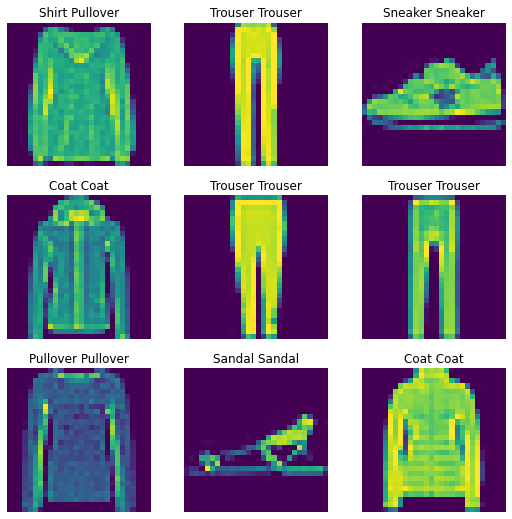

In [87]:
plt.figure(figsize=(9,9))
nrows = 3
ncol = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncol, i+1)
    plt.imshow(sample.squeeze())

    pred_label = class_names[q[i]]

    truth_label = class_names[test_labels[i]]

    plt.title(f"{pred_label} {truth_label}")

    plt.axis(False)